# Scraping the [justETF Screener](https://www.justetf.com/en/find-etf.html)

## Content

- [Request the data](#request)
- [Clean up the data](#cleanup)
- [Enrich the data](#enrich)
- [Save the data](#save)
- [Visualize some statistics](#visualize)
- [Search over the data](#search)

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%aimport utils

In [3]:
pd.set_option("display.max_columns", None)

<a id="request"></a>
## Request the data

In [4]:
last_four_years = [
    str((pd.Timestamp("now") - pd.DateOffset(years=i)).year) for i in range(1, 5)
]

In [5]:
DETAILS_KEY_MAPPING = {
    # IDs
    "isin": "isin",
    "wkn": "wkn",
    "ticker": "ticker",
    "valorNumber": "valor",
    # Basic info
    "name": "name",
    "groupValue": "index",
    "inceptionDate": "date",
    "strategy": "strategy",  # Custom field added during request
    "domicileCountry": "domicile_country",
    "fundCurrency": "currency",
    "hasSecuritiesLending": "securities_lending",
    "distributionPolicy": "dividends",
    "ter": "ter",
    "replicationMethod": "replication",
    "fundSize": "size",
    # Value return
    "ytdReturnCUR": "yesterday",
    "weekReturnCUR": "last_week",
    "monthReturnCUR": "last_month",
    "threeMonthReturnCUR": "last_three_months",
    "sixMonthReturnCUR": "last_six_months",
    "yearReturnCUR": "last_year",
    "threeYearReturnCUR": "last_three_years",
    "fiveYearReturnCUR": "last_five_years",
    "yearReturn1CUR": last_four_years[0],
    "yearReturn2CUR": last_four_years[1],
    "yearReturn3CUR": last_four_years[2],
    "yearReturn4CUR": last_four_years[3],
    # Dividends
    "currentDividendYield": "last_dividends",
    "yearDividendYield": "last_year_dividends",
    # Volatility
    "yearVolatilityCUR": "last_year_volatility",
    "threeYearVolatilityCUR": "last_three_years_volatility",
    "fiveYearVolatilityCUR": "last_five_years_volatility",
    # Return/Risk
    "yearReturnPerRiskCUR": "last_year_return_per_risk",
    "threeYearReturnPerRiskCUR": "last_three_years_return_per_risk",
    "fiveYearReturnPerRiskCUR": "last_five_years_return_per_risk",
}

In [6]:
INT64_COLUMNS = ["valor", "size"]
CATEGORY_COLUMNS = ["strategy", "domicile_country", "dividends", "replication"]
FLOAT_COLUMNS = [
    "ter",
    "yesterday",
    "last_week",
    "last_month",
    "last_three_months",
    "last_six_months",
    "last_year",
    "last_three_years",
    "last_five_years",
    "last_dividends",
    "last_year_dividends",
    "last_year_volatility",
    "last_three_years_volatility",
    "last_five_years_volatility",
    "last_year_return_per_risk",
    "last_three_years_return_per_risk",
    "last_five_years_return_per_risk",
] + last_four_years

In [7]:
data = {key: [] for key in DETAILS_KEY_MAPPING}
for sample in utils.make_request():
    for key, values in data.items():
        values.append(sample[key])

In [8]:
etf_df = pd.DataFrame(data).rename(columns=DETAILS_KEY_MAPPING)

In [9]:
etf_df.shape

(3290, 35)

In [10]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,strategy,domicile_country,currency,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,GB00BM9JYH62,A3GZKD,AVMX,-,Global X Aave ETP,Aave,13.03.23,Long-only,Jersey,USD,No,Accumulating,0.99%,Physically<br />backed,0,-4.25%,3.72%,16.50%,65.07%,46.13%,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,IE000GGQK173,A3D4VW,R8T,125589092,abrdn Global Real Estate Active Thematics UCIT...,abrdn Global Real Estate Active Thematics,22.02.23,Long-only,Ireland,USD,No,Accumulating,0.40%,Full replication,10,-0.96%,0.11%,2.66%,8.94%,5.23%,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,18.11.05,Long-only,Ireland,EUR,Yes,Distributing,0.30%,Full replication,571,-1.56%,-0.73%,-1.52%,5.31%,3.47%,7.22%,28.09%,72.86%,16.77%,-11.78%,29.89%,5.14%,2.16%,2.26%,11.99%,16.28%,18.48%,0.60,0.53,0.63


In [11]:
len(etf_df["isin"].unique())

3150

<a id="cleanup"></a>
## Clean up the data

In [12]:
for column in etf_df:
    etf_df[column] = (
        etf_df[column]
        .str.replace("<br />", " ")
        .str.replace(",", "")
        .replace("-", pd.NA)
    )

In [13]:
etf_df["valor"].unique().__len__()

2831

In [14]:
for column in INT64_COLUMNS:
    etf_df[column] = etf_df[column].astype("Int64")

In [15]:
for column in CATEGORY_COLUMNS:
    etf_df[column] = etf_df[column].astype("category")

In [16]:
for column in FLOAT_COLUMNS:
    etf_df[column] = (
        etf_df[column].str.removesuffix("%").replace(pd.NA, "nan").astype("float64")
    )

In [17]:
etf_df["date"] = pd.to_datetime(etf_df["date"], format="%d.%m.%y")

Keep insertion date, but also calculate age in years to simplify search over dataset.

In [18]:
columns = etf_df.columns.tolist()
etf_df["age"] = (
    pd.Timestamp("now") - pd.to_datetime(etf_df["date"], format="%d.%m.%y")
) / pd.to_timedelta(365, unit="D")
columns.insert(columns.index("date") + 1, "age")
etf_df = etf_df[columns]

In [19]:
etf_df["securities_lending"] = (
    etf_df["securities_lending"].replace({"Yes": True, "No": False}).astype("bool")
)

Separate hedged flag from currency.

In [20]:
columns = etf_df.columns.tolist()
columns.insert(columns.index("currency") + 1, "hedged")
etf_df["hedged"] = etf_df["currency"].str.endswith("Hedged")
etf_df["currency"] = etf_df["currency"].str.removesuffix(" Hedged").astype("category")
etf_df = etf_df[columns]

In [21]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,GB00BM9JYH62,A3GZKD,AVMX,<NA>,Global X Aave ETP,Aave,2023-03-13,0.838232,Long-only,Jersey,USD,False,False,Accumulating,0.99,Physically backed,0,-4.25,3.72,16.50,65.07,46.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IE000GGQK173,A3D4VW,R8T,125589092,abrdn Global Real Estate Active Thematics UCIT...,abrdn Global Real Estate Active Thematics,2023-02-22,0.890286,Long-only,Ireland,USD,False,False,Accumulating,0.40,Full replication,10,-0.96,0.11,2.66,8.94,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,18.164259,Long-only,Ireland,EUR,False,True,Distributing,0.30,Full replication,571,-1.56,-0.73,-1.52,5.31,3.47,7.22,28.09,72.86,16.77,-11.78,29.89,5.14,2.16,2.26,11.99,16.28,18.48,0.6,0.53,0.63


<a id="enrich"></a>
## Enrich the data

In [22]:
columns = etf_df.columns.tolist()

In [23]:
etf_df["asset"] = pd.NA
for asset, name in utils.ASSETS.items():
    isins = {sample["isin"] for sample in utils.make_request(asset=asset)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "asset"] = name
etf_df["asset"] = etf_df["asset"].astype("category")

In [24]:
etf_df["instrument"] = pd.NA
for instrument, name in utils.INSTRUMENTS.items():
    isins = {sample["isin"] for sample in utils.make_request(instrument=instrument)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "instrument"] = name
etf_df["instrument"] = etf_df["instrument"].astype("category")

In [25]:
etf_df["region"] = pd.NA
for region, name in utils.REGIONS.items():
    isins = {sample["isin"] for sample in utils.make_request(region=region)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "region"] = name
etf_df["region"] = etf_df["region"].astype("category")

In [26]:
new_columns = ["asset", "instrument", "region"]
for exchange, name in utils.EXCHANGES.items():
    name = f"at_{name}"
    etf_df[name] = False
    new_columns.append(name)
    isins = {sample["isin"] for sample in utils.make_request(exchange=exchange)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, name] = True

In [27]:
etf_df = etf_df[
    columns[: columns.index("size") + 1]
    + new_columns
    + columns[columns.index("size") + 1 :]
]

In [28]:
etf_df.shape

(3290, 49)

In [29]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_XETRA,at_London,at_Euronext Paris,at_Stuttgart,at_SIX Swiss Exchange,at_Borsa Italiana,at_Euronext Amsterdam,at_Euronext Brussels,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,GB00BM9JYH62,A3GZKD,AVMX,<NA>,Global X Aave ETP,Aave,2023-03-13,0.838232,Long-only,Jersey,USD,False,False,Accumulating,0.99,Physically backed,0,Cryptocurrencies,ETN,NaN,True,True,False,False,False,False,False,False,False,-4.25,3.72,16.50,65.07,46.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IE000GGQK173,A3D4VW,R8T,125589092,abrdn Global Real Estate Active Thematics UCIT...,abrdn Global Real Estate Active Thematics,2023-02-22,0.890286,Long-only,Ireland,USD,False,False,Accumulating,0.40,Full replication,10,Real Estate,ETF,World,True,True,False,False,False,False,False,False,False,-0.96,0.11,2.66,8.94,5.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,18.164259,Long-only,Ireland,EUR,False,True,Distributing,0.30,Full replication,571,Equity,ETF,NaN,True,False,True,False,False,True,False,True,False,-1.56,-0.73,-1.52,5.31,3.47,7.22,28.09,72.86,16.77,-11.78,29.89,5.14,2.16,2.26,11.99,16.28,18.48,0.6,0.53,0.63


<a id="save"></a>
## Save the data

In [30]:
etf_df.to_csv("justetf.csv", index=False)

<a id="visualize"></a>
## Visualize some statistics

<Axes: xlabel='Count', ylabel='strategy'>

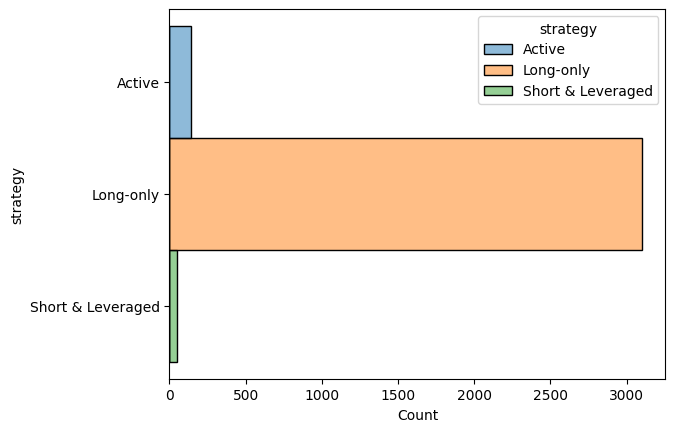

In [31]:
sns.histplot(etf_df, y="strategy", hue="strategy", discrete=True)

<Axes: xlabel='Count', ylabel='instrument'>

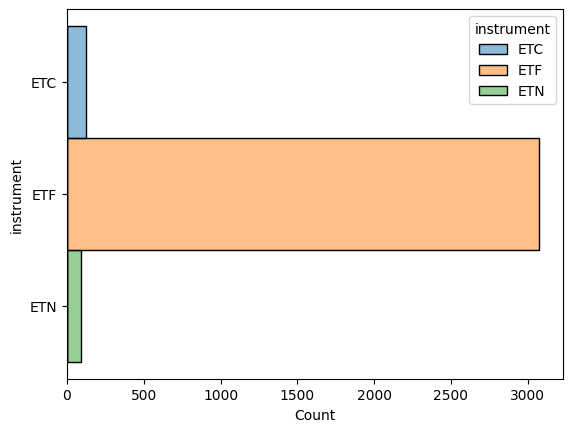

In [32]:
sns.histplot(etf_df, y="instrument", hue="instrument", discrete=True)

<Axes: xlabel='Count', ylabel='asset'>

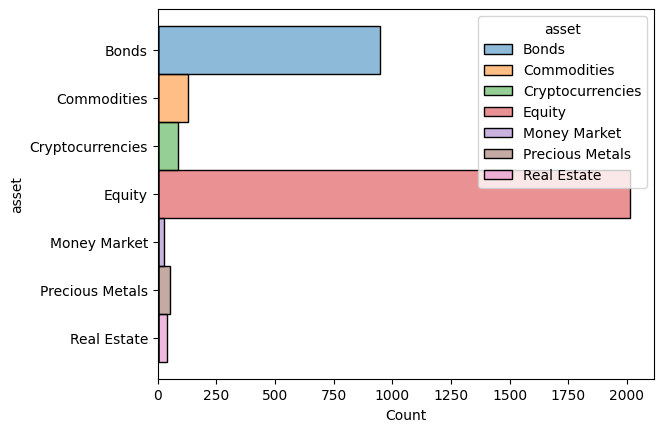

In [33]:
sns.histplot(etf_df, y="asset", hue="asset", discrete=True)

<Axes: xlabel='Count', ylabel='region'>

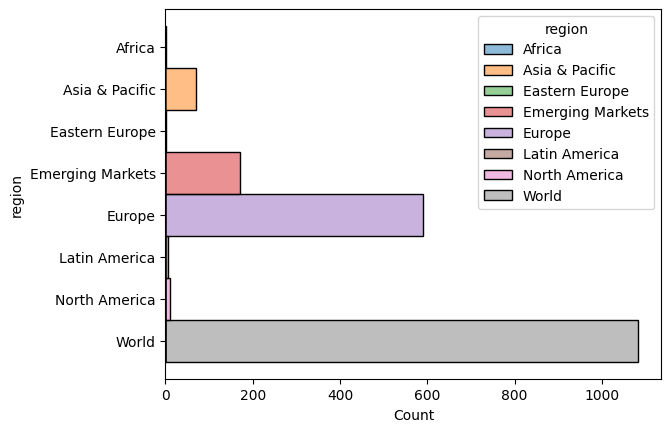

In [34]:
sns.histplot(etf_df, y="region", hue="region", discrete=True)

<Axes: xlabel='Count', ylabel='currency'>

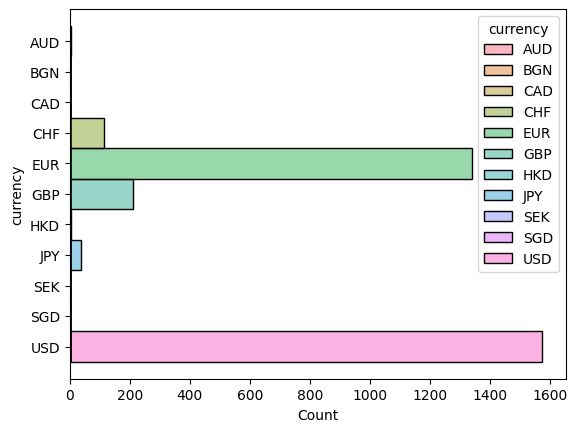

In [35]:
sns.histplot(etf_df, y="currency", hue="currency", discrete=True)

<Axes: xlabel='age', ylabel='size'>

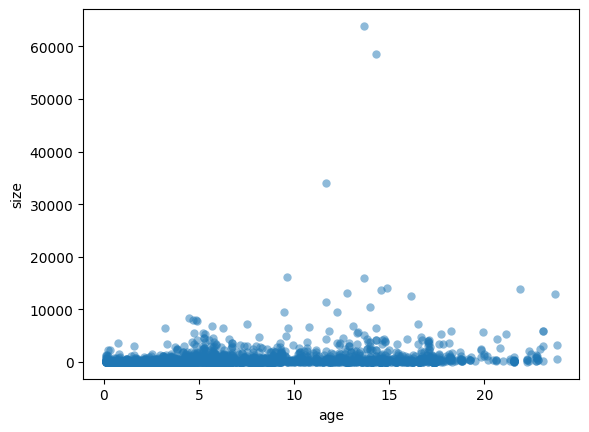

In [36]:
sns.scatterplot(data=etf_df, x="age", y="size", alpha=0.5, linewidth=0)

The most frequent indices.

In [37]:
index_counts = etf_df["index"].value_counts()

<Axes: xlabel='Count', ylabel='index'>

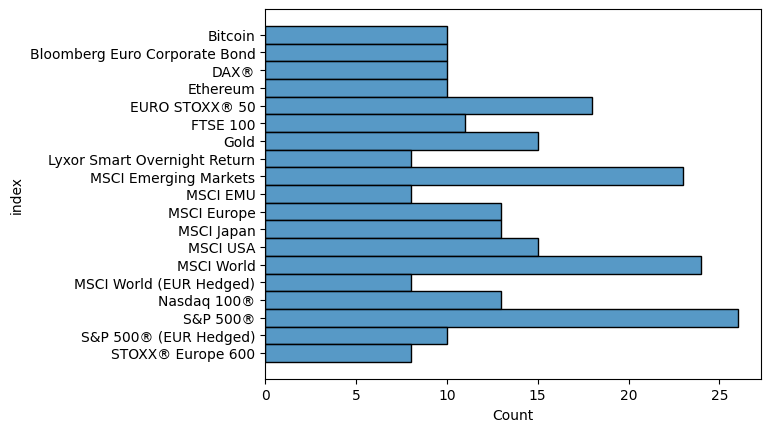

In [38]:
sns.histplot(
    etf_df[etf_df["index"].isin(index_counts[index_counts > 7].index)],
    y="index",
    discrete=True,
)

<a id="search"></a>
## Search over the data

Compare accumulating MSCI World ETFs older than 2 years with fond size greater than € 50M.

In [39]:
acc_msci_world_df = etf_df[
    (etf_df["index"] == "MSCI World")
    & (etf_df["dividends"] == "Accumulating")
    & (etf_df["age"] > 2)
    & (etf_df["size"] > 50)
]

In [40]:
acc_msci_world_df.shape

(10, 49)

In [41]:
acc_msci_world_df

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_XETRA,at_London,at_Euronext Paris,at_Stuttgart,at_SIX Swiss Exchange,at_Borsa Italiana,at_Euronext Amsterdam,at_Euronext Brussels,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2023,2022,2021,2020,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
2160,LU1437016972,A2ATYV,XPAN,34333476,Amundi Index MSCI World UCITS ETF DR (C),MSCI World,2016-06-29,7.545081,Long-only,Luxembourg,EUR,False,True,Accumulating,0.18,Full replication,1110,Equity,ETF,World,True,False,True,True,False,False,True,True,False,0.05,0.92,1.06,5.27,7.42,15.99,33.25,81.99,19.52,-13.37,31.51,6.34,NaN,NaN,11.49,15.40,18.07,1.39,0.65,0.70
2162,FR0014003IY1,LYX9ZB,WLDC,<NA>,Amundi MSCI World II UCITS ETF Acc,MSCI World,2021-06-02,2.616314,Long-only,France,EUR,False,False,Accumulating,0.30,Swap based Unfunded,62,Equity,ETF,World,False,False,False,False,False,False,True,False,False,0.49,0.90,1.91,6.13,8.75,17.82,NaN,NaN,19.77,-12.72,NaN,NaN,NaN,NaN,10.69,NaN,NaN,1.67,NaN,NaN
2166,LU1681043599,A2H59Q,AMEW,38784696,Amundi MSCI World UCITS ETF EUR (C),MSCI World,2018-04-18,5.742341,Long-only,Luxembourg,EUR,False,False,Accumulating,0.38,Swap based Unfunded,2906,Equity,ETF,World,True,True,False,True,True,True,True,False,False,0.06,0.98,0.98,5.46,7.50,16.04,33.41,81.76,19.46,-12.87,30.94,6.26,NaN,NaN,10.72,14.11,17.38,1.50,0.71,0.73
2167,LU1681043672,A2H59R,XAMZ,38784715,Amundi MSCI World UCITS ETF USD (C),MSCI World,2018-04-18,5.742341,Long-only,Luxembourg,USD,False,False,Accumulating,0.38,Swap based Unfunded,62,Equity,ETF,World,True,False,True,True,False,True,False,False,False,-0.16,0.70,0.84,5.00,7.20,15.67,33.20,82.17,19.35,-13.17,31.85,6.04,NaN,NaN,11.71,15.31,18.18,1.34,0.65,0.70
2168,LU1781541179,LYX0YD,LCUW,40587053,Amundi MSCI World V UCITS ETF Acc,MSCI World,2018-02-28,5.876588,Long-only,Luxembourg,USD,False,True,Accumulating,0.12,Full replication,3429,Equity,ETF,World,True,True,True,True,True,False,True,False,False,0.13,1.01,1.15,5.35,7.54,16.14,33.90,83.23,19.60,-13.25,31.96,6.12,NaN,NaN,11.43,16.33,18.71,1.41,0.63,0.69
2172,IE00B60SX394,A0RGCS,SC0J,10128224,Invesco MSCI World UCITS ETF Acc,MSCI World,2009-04-02,14.791656,Long-only,Ireland,USD,False,False,Accumulating,0.19,Swap based Unfunded,3810,Equity,ETF,World,True,True,True,False,True,True,True,False,False,0.06,0.92,1.08,5.27,7.54,16.21,34.43,84.90,19.66,-12.96,32.12,6.28,NaN,NaN,11.45,15.26,18.19,1.42,0.68,0.72
2173,IE00B4L5Y983,A0RPWH,EUNL,10608388,iShares Core MSCI World UCITS ETF USD (Acc),MSCI World,2009-09-25,14.309464,Long-only,Ireland,USD,False,True,Accumulating,0.20,Optimized sampling,58519,Equity,ETF,World,True,True,True,False,True,True,True,True,False,0.10,0.96,1.11,5.29,7.56,16.18,34.33,84.27,19.55,-12.96,32.10,6.13,NaN,NaN,11.46,15.26,18.15,1.41,0.68,0.72
2176,IE00BFY0GT14,A2N6CW,SPPW,46170158,SPDR MSCI World UCITS ETF,MSCI World,2019-02-28,4.876588,Long-only,Ireland,USD,False,True,Accumulating,0.12,Optimized sampling,4085,Equity,ETF,World,True,True,True,False,False,True,True,True,False,0.13,0.94,1.11,5.31,7.62,16.27,34.80,NaN,19.60,-12.74,32.09,6.06,NaN,NaN,11.42,15.22,NaN,1.43,0.69,NaN
2180,LU0274208692,DBX1MW,DBXW,2825395,Xtrackers MSCI World Swap UCITS ETF 1C,MSCI World,2006-12-19,17.079327,Long-only,Luxembourg,USD,False,False,Accumulating,0.45,Swap based Unfunded,3533,Equity,ETF,World,True,True,True,False,True,True,True,False,False,0.05,0.90,1.05,5.21,7.45,15.99,33.69,83.52,19.44,-13.13,31.91,6.14,NaN,NaN,11.47,15.24,18.18,1.39,0.67,0.71
2182,IE00BJ0KDQ92,A1XB5U,XDWD,24869934,Xtrackers MSCI World UCITS ETF 1C,MSCI World,2014-07-22,9.484807,Long-only,Ireland,USD,False,True,Accumulating,0.19,Optimized sampling,954

In [42]:
COLUMNS_MAPPINGS = {
    "Short-term return": {
        "isin": "isin",
        "last_six_months": "Last 5 months",
        "last_three_months": "Last 3 months",
        "last_month": "Last month",
        "last_week": "Last week",
        "yesterday": "Yesterday",
    },
    "Mid-term return": {
        "isin": "isin",
        "last_five_years": "last 5 years",
        "last_three_years": "last 3 years",
        "last_year": "last year",
    },
    "Volatility": {
        "isin": "isin",
        "last_five_years_volatility": "Last 5 years",
        "last_three_years_volatility": "Last 3 years",
        "last_year_volatility": "Last year",
    },
    "Return/Risk": {
        "isin": "isin",
        "last_five_years_return_per_risk": "Last 5 years",
        "last_three_years_return_per_risk": "Last 3 years",
        "last_year_return_per_risk": "Last year",
    },
}

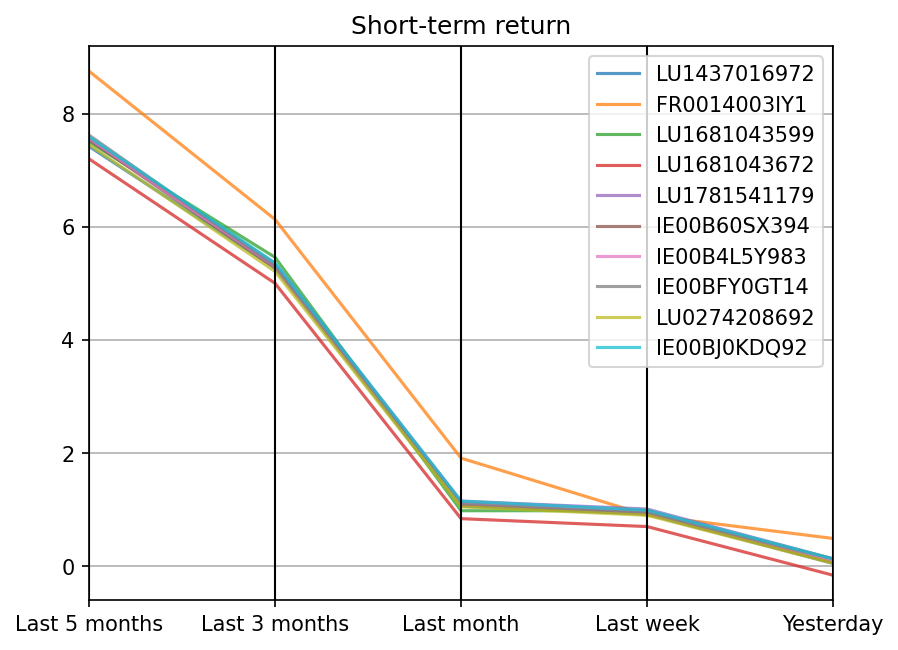

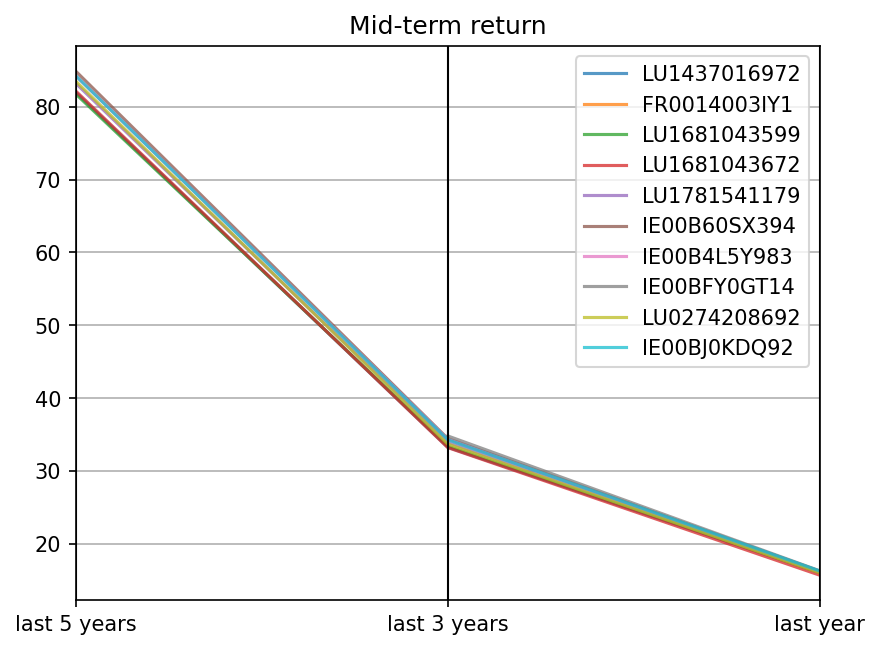

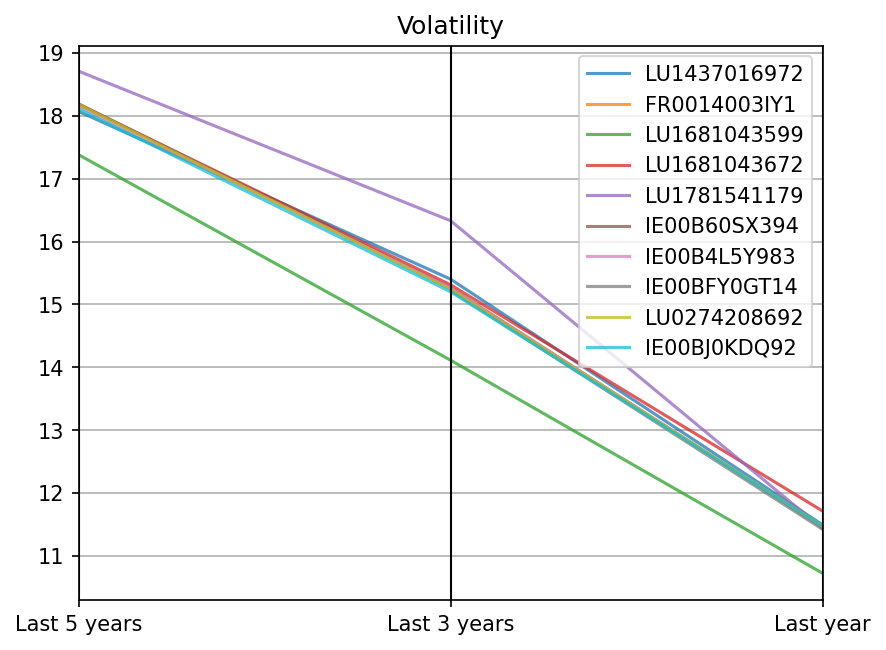

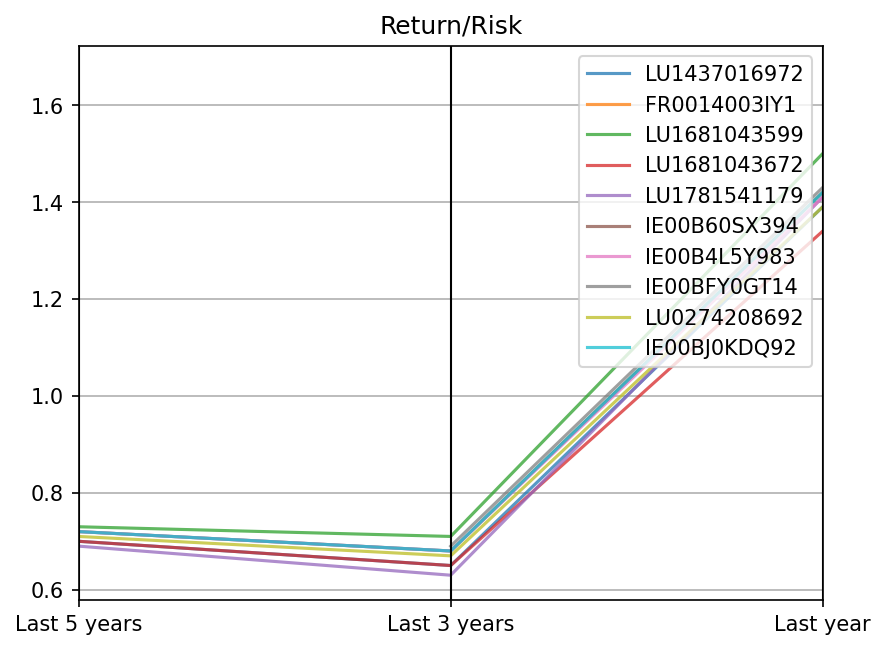

In [43]:
for title, mapping in COLUMNS_MAPPINGS.items():
    df = acc_msci_world_df[mapping.keys()].rename(columns=mapping)
    plt.figure(dpi=150)
    ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
    _ = ax.set_title(title)

In [44]:
df = acc_msci_world_df[["isin"] + list(reversed(last_four_years))]

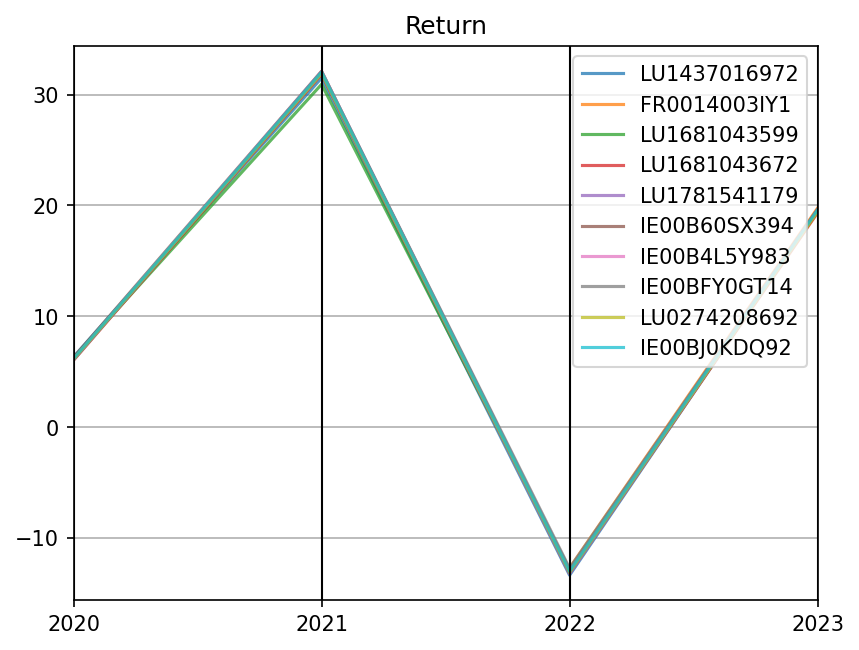

In [45]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return")

In [46]:
df = df.set_index("isin")

In [47]:
ter = (100 - acc_msci_world_df.set_index("isin")["ter"]) / 100

In [48]:
df = ((100 + df) / 100).mul(ter, axis=0)

In [49]:
cum_df = df.copy()

In [50]:
df = (df * 100 - 100).reset_index()

In [51]:
cum_df[last_four_years[1]] *= cum_df[last_four_years[0]]
cum_df[last_four_years[2]] *= cum_df[last_four_years[1]]
cum_df[last_four_years[3]] *= cum_df[last_four_years[2]]

In [52]:
cum_df = (cum_df * 100 - 100).reset_index()

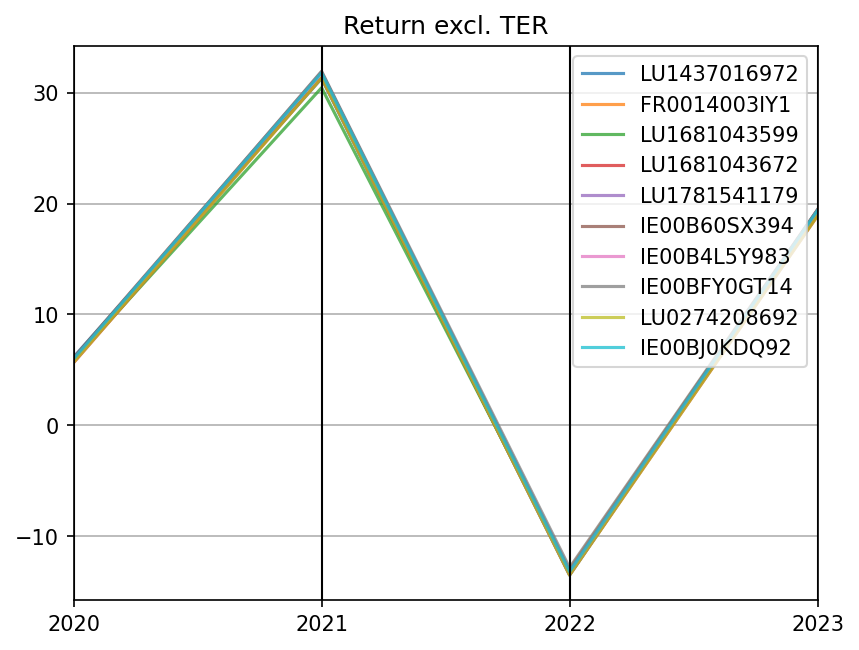

In [53]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return excl. TER")

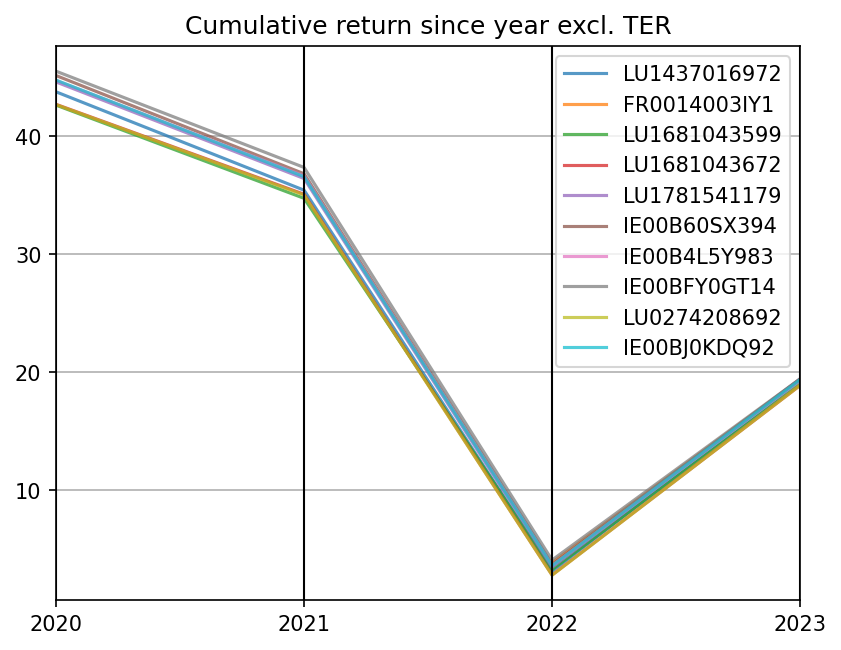

In [54]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(cum_df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Cumulative return since year excl. TER")